# First iteration of tree-based models.

The hyperparameter optization process will be the following:
1. Train with default hyperaparameters.
2. Identify bias and variance.
3. Choose first range for hyperparameters based on results.
4. Train n models using HalvingRandomSearchCV from scikit learn.
5. Pick the regions of the hyperparameter space that yield the best results.
6. Centre the hyperparameter search on those regions and iterate.

The scoring will consist in:
1. Numerical scores for the testing subset: recall, precision, roc_auc, f1.
2. Numerical scores for the whole data: recall, precision, roc_auc, f1.
2. Visualization of the ROC curve for the whole data.
4. Confusion matrix for the whole data.

In this way we can see if each model over/underfits, comparing the test and total scores. Also, the ROC curve and the confusion matrix will show how each model is performing in the whole dataset.


In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
# For random number generation
from scipy.stats import randint, uniform

from sklearn.experimental import enable_halving_search_cv # Allow importing the experimental HalvingGridSearchCV

# Metrics and auxiliar libraries from sklearn.
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV, RepeatedStratifiedKFold, HalvingGridSearchCV

# Some auxiliary functions for scoring.
import scoring_utils

#DEV
import importlib as imp


In [2]:
# Import the dataframe cleaned and encoded during the feature importance process.
df_encoded = pd.read_csv('../data/df_encoded.csv')

In [3]:
target = 'Default'
features_encoded = [feature for feature in df_encoded.columns if feature not in target]
# Our target and features are the same that we employed during the importance analysis.
print(f"Target: {target}")
print(f"Features: {features_encoded}")

Target: Default
Features: ['NAICS', 'Term', 'NewExist', 'FranchiseCode', 'RevLineCr', 'LowDoc', 'GrAppv', 'SBA_Appv', 'isNewBusiness', 'isFranchise', 'SBARatio', 'NAICS_i_0', 'NAICS_i_11', 'NAICS_i_21', 'NAICS_i_22', 'NAICS_i_23', 'NAICS_i_31', 'NAICS_i_32', 'NAICS_i_33', 'NAICS_i_42', 'NAICS_i_44', 'NAICS_i_45', 'NAICS_i_48', 'NAICS_i_49', 'NAICS_i_51', 'NAICS_i_52', 'NAICS_i_53', 'NAICS_i_54', 'NAICS_i_55', 'NAICS_i_56', 'NAICS_i_61', 'NAICS_i_62', 'NAICS_i_71', 'NAICS_i_72', 'NAICS_i_81', 'NAICS_i_92', 'UrbanRural_0', 'UrbanRural_1', 'UrbanRural_2']


In [4]:
# This split will be used in every model, so that they are scored against the same subset.
X_train, X_test, y_train, y_test = train_test_split(df_encoded[features_encoded], df_encoded[target], train_size = .9)
# Complete datasets
X_total = df_encoded[features_encoded]
y_total = df_encoded[target]

### Single Decision Tree Classifier

In [5]:
# Default check to identify bias/variance
from sklearn.tree import DecisionTreeClassifier

default_tree = DecisionTreeClassifier()
default_tree.fit(X_train, y_train)

yhat_train = default_tree.predict(X_train)
yhat_test = default_tree.predict(X_test)

default_tree_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, "Default Tree Train"),
    scoring_utils.get_metrics(y_test, yhat_test, "Default Tree Test")
    ))

default_tree_score

,Recall,Precision,ROC,F1
Default Tree Train,0.974344,0.997530,0.986922,0.985801
Default Tree Test,0.756122,0.764873,0.853971,0.760472


In [6]:
default_tree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

It does overfit! Let's decrease the variance by tuning the hyperparameters.

In [7]:

# Grid of parameters for a single tree
param_grid = [
    {
        "min_samples_split": randint(100, 200),
        "max_depth": randint(14, 18)
    }
]

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

single_tree_search = HalvingRandomSearchCV(
    estimator=DecisionTreeClassifier(class_weight='balanced'),
    param_distributions=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    n_candidates=1000
)

single_tree_search.fit(X_train, y_train)


HalvingRandomSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                      estimator=DecisionTreeClassifier(class_weight='balanced'),
                      n_candidates=1000, n_jobs=-1,
                      param_distributions=[{'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17ff0ffd0>,
                                            'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x157e10810>}],
                      scoring='recall')

In [8]:
scoring_utils.get_best_kernels(single_tree_search.cv_results_)

,params,rank_test_score,mean_test_score
kernel,,,
16_165,"{'max_depth': 16, 'min_samples_split': 165}",1,0.890727
16_166,"{'max_depth': 16, 'min_samples_split': 166}",2,0.890288
16_165,"{'max_depth': 16, 'min_samples_split': 165}",3,0.887195
16_160,"{'max_depth': 16, 'min_samples_split': 160}",3,0.887195
16_166,"{'max_depth': 16, 'min_samples_split': 166}",3,0.887195
...,...,...,...
16_175,"{'max_depth': 16, 'min_samples_split': 175}",1171,0.222222
15_184,"{'max_depth': 15, 'min_samples_split': 184}",1171,0.222222
15_184,"{'max_depth': 15, 'min_samples_split': 184}",1171,0.222222


In [9]:
# Let's use the best estimator to obtain test and overall scores 
single_tree_model = single_tree_search.best_estimator_

yhat_test = single_tree_model.predict(X_test)
yhat_total = single_tree_model.predict(X_total)

In [10]:
single_tree_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Single Tree Test")
single_tree_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Single Tree Total")

single_tree_score = pd.concat((single_tree_test_score, single_tree_total_score))
single_tree_score

,Recall,Precision,ROC,F1
Single Tree Test,0.919577,0.676311,0.914175,0.779403
Single Tree Total,0.934664,0.691592,0.924205,0.794963


In [11]:
print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")

We obtained a profit of $6,637,183,694.35


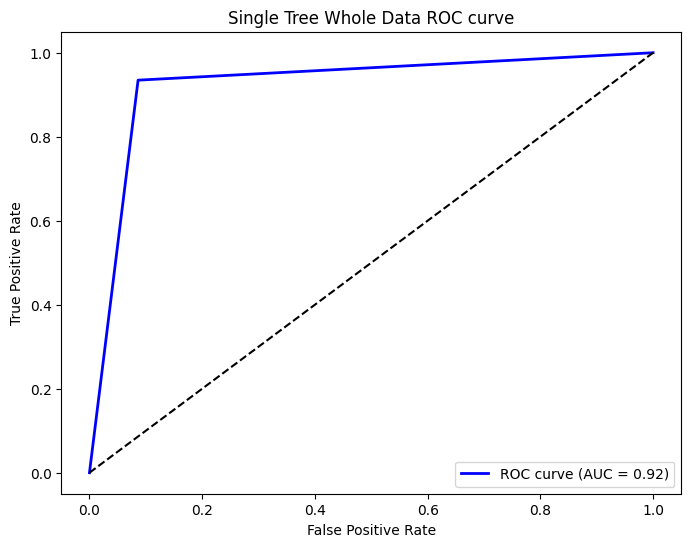

In [12]:
scoring_utils.get_roc_plot(y_total, yhat_total, "Single Tree Whole Data")

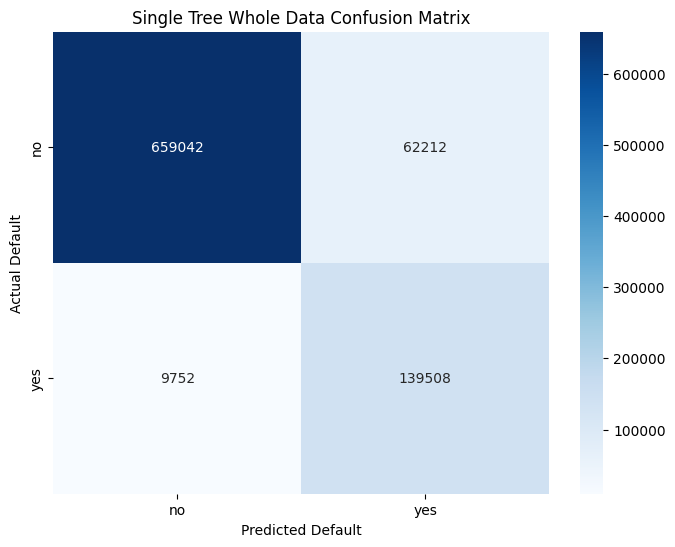

In [13]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Single Tree Whole Data")

### Bagging classifier

In [14]:
# Default check to identify bias/variance
from sklearn.ensemble import BaggingClassifier

default_bagging = BaggingClassifier(DecisionTreeClassifier(), n_jobs=-1)
default_bagging.fit(X_train, y_train)

yhat_train = default_bagging.predict(X_train)
yhat_test = default_bagging.predict(X_test)

default_bagging_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, "Default Bagging Train"),
    scoring_utils.get_metrics(y_test, yhat_test, "Default Bagging Test")
    ))

default_bagging_score

,Recall,Precision,ROC,F1
Default Bagging Train,0.956728,0.983288,0.976682,0.969826
Default Bagging Test,0.779607,0.814142,0.871358,0.796500


In [15]:
default_bagging.get_params()

{'base_estimator': 'deprecated',
 'bootstrap': True,
 'bootstrap_features': False,
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(),
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [16]:

# Grid of parameters for a bagging model
param_grid = [
    {
        "max_samples": [.8, .9, 1.0]
    }
]

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

bagging_search = HalvingGridSearchCV(
    estimator=BaggingClassifier(n_estimators=10, estimator=single_tree_model),
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

bagging_search.fit(X_train, y_train)


n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 261154
max_resources_: 783462
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 261154
Fitting 9 folds for each of 3 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 1
n_resources: 783462
Fitting 9 folds for each of 1 candidates, totalling 9 fits


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                    estimator=BaggingClassifier(estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                 max_depth=16,
                                                                                 min_samples_split=165)),
                    n_jobs=-1, param_grid=[{'max_samples': [0.8, 0.9, 1.0]}],
                    scoring='recall', verbose=1)

In [17]:
scoring_utils.get_best_kernels(bagging_search.cv_results_)

,params,rank_test_score,mean_test_score
kernel,,,
1.0,{'max_samples': 1.0},1,0.923550
1.0,{'max_samples': 1.0},2,0.922421
0.8,{'max_samples': 0.8},3,0.920675
0.9,{'max_samples': 0.9},4,0.920195


In [18]:
bagging_model = bagging_search.best_estimator_

yhat_test = bagging_model.predict(X_test)
yhat_total = bagging_model.predict(X_total)

In [19]:
bagging_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Bagging Test")
bagging_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Bagging Total")

bagging_score = pd.concat((bagging_test_score, bagging_total_score, single_tree_score))
bagging_score

,Recall,Precision,ROC,F1
Bagging Test,0.923792,0.690972,0.919077,0.790598
Bagging Total,0.933184,0.703879,0.925970,0.802472
Single Tree Test,0.919577,0.676311,0.914175,0.779403
Single Tree Total,0.934664,0.691592,0.924205,0.794963


In [20]:
print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")

We obtained a profit of $6,697,070,575.55


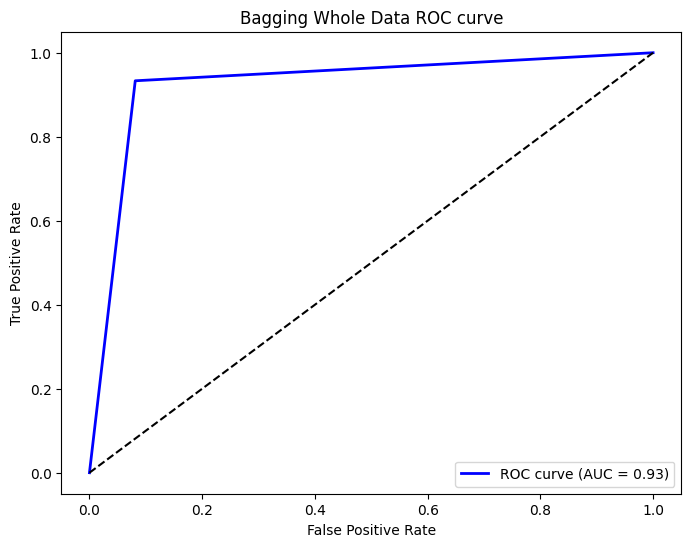

In [21]:
scoring_utils.get_roc_plot(y_total, yhat_total, "Bagging Whole Data")

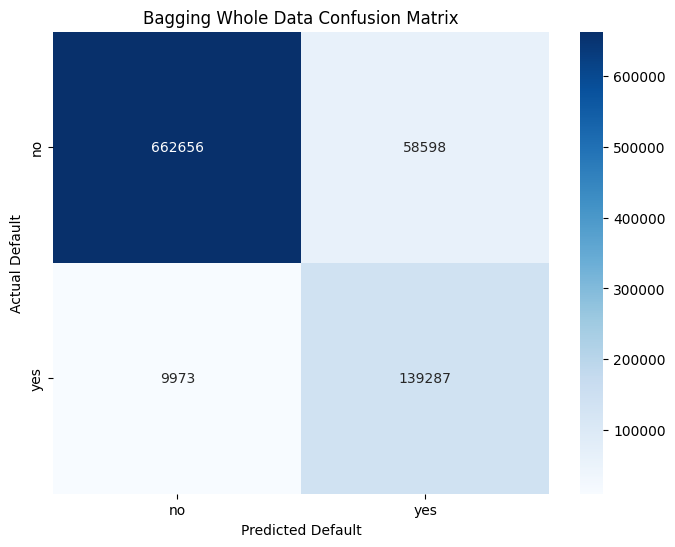

In [22]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Bagging Whole Data")

### Random forest

In [23]:
# Default to check bias/variance
from sklearn.ensemble import RandomForestClassifier

default_forest = RandomForestClassifier().fit(X_train, y_train)

yhat_train = default_forest.predict(X_train)
yhat_test = default_forest.predict(X_test)

default_forest_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, 'Default Forest Train'),
    scoring_utils.get_metrics(y_test, yhat_test, 'Default Forest Test')
))

default_forest_score


,Recall,Precision,ROC,F1
Default Forest Train,0.980508,0.991224,0.989356,0.985837
Default Forest Test,0.742205,0.819095,0.854114,0.778757


In [24]:
default_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [25]:
# {'max_depth': 14, 'min_samples_split': 109} # One of my best trees!!!!!

param_grid = {
    'max_depth': [10, 100, None], # This has a smaller effect, but 100 seems to work out fine.
    'min_samples_split': [10, 100, 1000] # This should be around 100
}

# Cross validation in 3 folds for our grid search parameter selection.
# It must be consistent across the folds, so the random state has to be fixed.
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=9)

random_forest_search = HalvingGridSearchCV(
    estimator=RandomForestClassifier(n_estimators=50, max_features=1.0, class_weight='balanced'),
    param_grid=param_grid,
    scoring='recall',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

random_forest_search.fit(X_train, y_train)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 87051
max_resources_: 783462
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 9
n_resources: 87051
Fitting 9 folds for each of 9 candidates, totalling 81 fits
----------
iter: 1
n_candidates: 3
n_resources: 261153
Fitting 9 folds for each of 3 candidates, totalling 27 fits
----------
iter: 2
n_candidates: 1
n_resources: 783459
Fitting 9 folds for each of 1 candidates, totalling 9 fits


HalvingGridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=9),
                    estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_features=1.0,
                                                     n_estimators=50),
                    n_jobs=-1,
                    param_grid={'max_depth': [10, 100, None],
                                'min_samples_split': [10, 100, 1000]},
                    scoring='recall', verbose=1)

In [26]:
scoring_utils.get_best_kernels(random_forest_search.cv_results_)

,params,rank_test_score,mean_test_score
kernel,,,
100_100,"{'max_depth': 100, 'min_samples_split': 100}",1,0.920445
100_100,"{'max_depth': 100, 'min_samples_split': 100}",2,0.916297
None_100,"{'max_depth': None, 'min_samples_split': 100}",3,0.915885
10_100,"{'max_depth': 10, 'min_samples_split': 100}",4,0.914734
10_100,"{'max_depth': 10, 'min_samples_split': 100}",5,0.907676
None_100,"{'max_depth': None, 'min_samples_split': 100}",6,0.906288
100_100,"{'max_depth': 100, 'min_samples_split': 100}",7,0.905210
100_1000,"{'max_depth': 100, 'min_samples_split': 1000}",8,0.898693
10_10,"{'max_depth': 10, 'min_samples_split': 10}",9,0.896858


In [28]:
random_forest = random_forest_search.best_estimator_

yhat_test = random_forest.predict(X_test)
yhat_total = random_forest.predict(X_total)

In [29]:
forest_test_score = scoring_utils.get_metrics(y_test, yhat_test, "Random Forest Test")
forest_total_score = scoring_utils.get_metrics(y_total, yhat_total, "Random Forest Total")

forest_score = pd.concat((forest_test_score, forest_total_score, bagging_score))
forest_score

,Recall,Precision,ROC,F1
Random Forest Test,0.919979,0.708873,0.920832,0.800745
Random Forest Total,0.938430,0.726885,0.932730,0.819221
Bagging Test,0.923792,0.690972,0.919077,0.790598
Bagging Total,0.933184,0.703879,0.925970,0.802472
Single Tree Test,0.919577,0.676311,0.914175,0.779403
Single Tree Total,0.934664,0.691592,0.924205,0.794963


In [30]:
print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")

We obtained a profit of $6,806,807,280.05


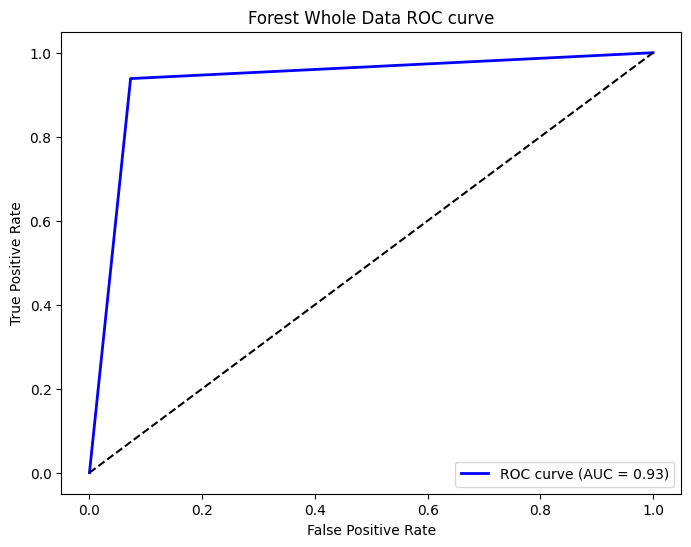

In [31]:
scoring_utils.get_roc_plot(y_total, yhat_total, "Forest Whole Data")

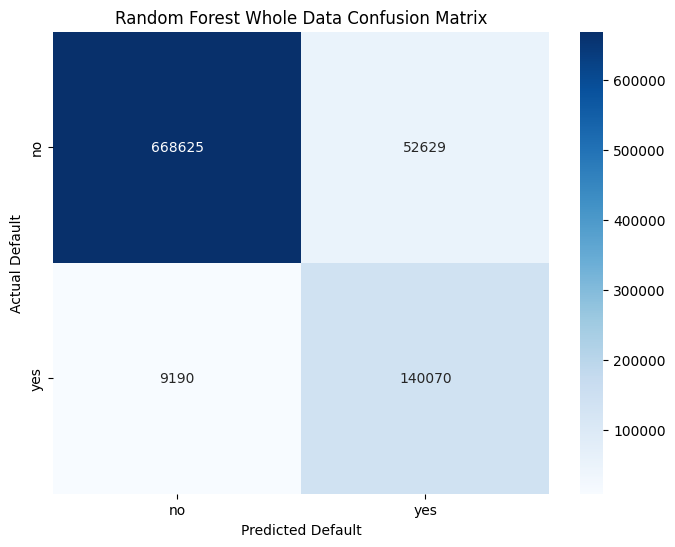

In [32]:
scoring_utils.get_confusion_matrix(y_total, yhat_total, "Random Forest Whole Data")

### Boosting

In [33]:
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

def modelfit(alg, X, y,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X.values, label=y.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [34]:

xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 verbosity=2,
 max_depth=11,
 min_child_weight=10,
 gamma=0.1,
 subsample=0.9,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=5,
 seed=27)
modelfit(xgb1, X_train, y_train)

/Users/alemalvarez/.pyenv/versions/3.11.5/lib/python3.11/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(



Model Report
Accuracy : 0.9232
AUC Score (Train): 0.979227


TypeError: 'NoneType' object is not callable

In [35]:
xgb1.get_params()


{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.8,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': 0.1,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.1,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 11,
 'max_leaves': None,
 'min_child_weight': 10,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': 5,
 'subsample': 0.9,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': 2,
 'seed': 27}

In [36]:
yhat_train = xgb1.predict(X_train)
yhat_test = xgb1.predict(X_test)

cv_boost_score = pd.concat((
    scoring_utils.get_metrics(y_train, yhat_train, 'CV Boosting Train'),
    scoring_utils.get_metrics(y_test, yhat_test, 'CV Boosting Test')
))

cv_boost_score

,Recall,Precision,ROC,F1
CV Boosting Train,0.939426,0.708121,0.929653,0.807537
CV Boosting Test,0.923458,0.691102,0.918952,0.790560


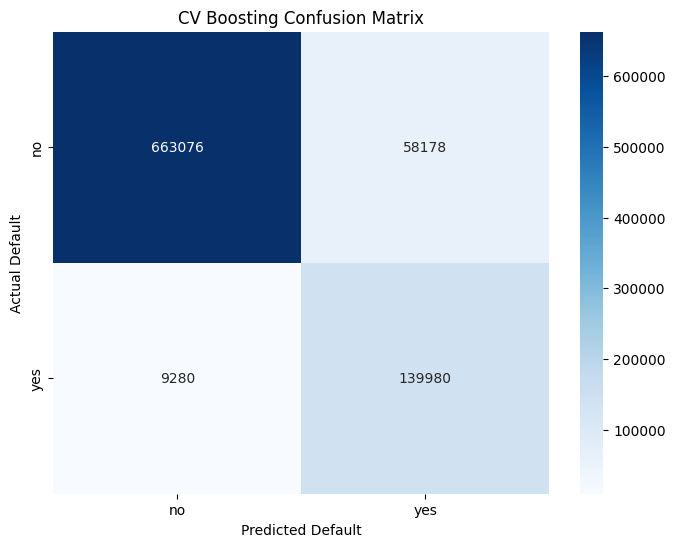

In [37]:
yhat_total = xgb1.predict(X_total)
scoring_utils.get_confusion_matrix(y_total, yhat_total, 'CV Boosting')

In [38]:
print(f"We obtained a profit of ${scoring_utils.get_profit(X_total, y_total, yhat_total):,.2f}")

We obtained a profit of $6,654,258,698.60
